In [ ]:
import numpy as np
from scipy import spatial
import faiss
import typing
from time import time
import matplotlib.pyplot as plt

## Helper Function

In [ ]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        distribution: str,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [ ]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [ ]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [ ]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [ ]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors.
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [ ]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors.
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [ ]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li>
 <li> optimized_exhaustive_search </li>
 <li> faiss_flatL2 </li>
</ol>

each one implements vector search with different levels of optimization. Your task is to compare the running time of these three methods.
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.

### Generate the following plots:
##### 1.1.1. Running time of the three methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
##### 1.1.2. Running time of the three methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 100000
* number of vectors in the query set: 1000

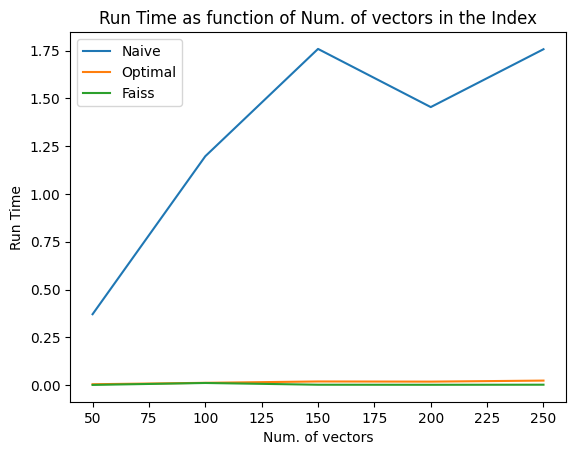

In [ ]:
#TODO: Write your code for 1.1.1 here
dim = 100
n_queries = 1000
n_index = [50, 100, 150, 200, 250]
run_time = [[],[],[]]
k = 5

queries = np.float32(generate_vectors(n_queries, dim, "uniform"))

for n in n_index:
  index = np.float32(generate_vectors(n, dim, "uniform"))

  start_naive = time()
  naive_exhaustive_search(queries, index, k)
  run_time[0].append(time()-start_naive)

  start_opt = time()
  optimized_exhaustive_search(queries, index, k)
  run_time[1].append(time()-start_opt)

  index_faiss = build_faiss_flatl2_index(index, dim)
  start_faiss = time()
  faiss_search(queries, index_faiss, k)
  run_time[2].append(time()-start_faiss)

plt.plot(n_index, run_time[0], label="Naive")
plt.plot(n_index, run_time[1], label="Optimal")
plt.plot(n_index, run_time[2], label="Faiss")
plt.legend()
plt.xlabel("Num. of vectors")
plt.ylabel("Run Time")
plt.title("Run Time as function of Num. of vectors in the Index")
plt.savefig('img111.png', bbox_inches='tight')
plt.show()

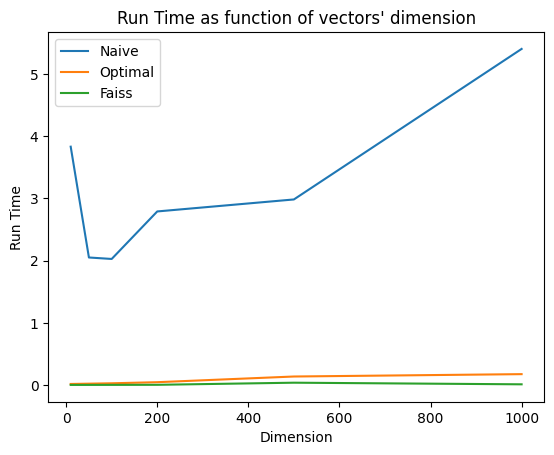

In [ ]:
#TODO Write your code for 1.1.2 here
dim = [10, 50, 100, 200, 500, 1000]
n_queries = 100
n_index = 100000 # CHANGE TO 100,000!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
run_time = [[],[]]
k = 5


for n in dim:
  queries = np.float32(generate_vectors(n_queries, n, "uniform"))
  index = np.float32(generate_vectors(n_index, n, "uniform"))

  start_opt = time()
  optimized_exhaustive_search(queries, index, k)
  run_time[0].append(time()-start_opt)

  index_faiss = build_faiss_flatl2_index(index, n)
  start_faiss = time()
  faiss_search(queries, index_faiss, k)
  run_time[1].append(time()-start_faiss)

plt.plot(dim, run_time[0], label="Optimal")
plt.plot(dim, run_time[1], label="Faiss")
plt.legend()
plt.xlabel("Dimension")
plt.ylabel("Run Time")
plt.title("Run Time as function of vectors' dimension")
plt.savefig('img112.png', bbox_inches='tight')
plt.show()

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells between the TODOs, but do not flip the order of the subsections.
When you finish. do not forget to attach the plots to report.pdf, placed under a clear title indicating the section number.


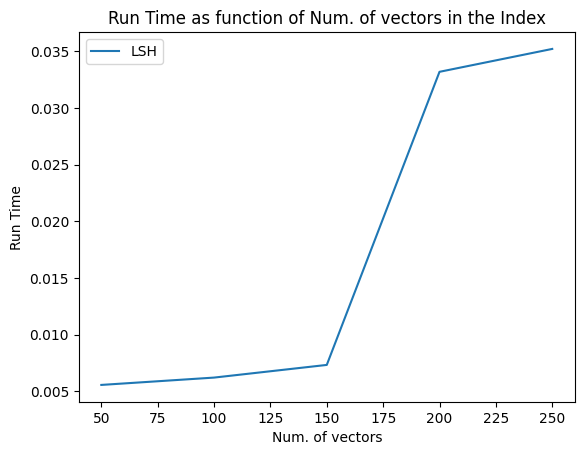

In [ ]:
#TODO: Write your code for 1.2.1 here
dim = 100
n_queries = 1000
nbits = 500
n_index = [50, 100, 150, 200, 250]
run_time = []
k = 5

queries = np.float32(generate_vectors(n_queries, dim, "uniform"))

for n in n_index:
  index = np.float32(generate_vectors(n, dim, "uniform"))

  index_faiss = build_faiss_lsh_index(index, dim, nbits)
  start_faiss = time()
  faiss_search(queries, index_faiss, k)
  run_time.append(time()-start_faiss)


plt.plot(n_index, run_time, label="LSH")
plt.legend()
plt.xlabel("Num. of vectors")
plt.ylabel("Run Time")
plt.title("Run Time as function of Num. of vectors in the Index")
plt.savefig('img121.png', bbox_inches='tight')
plt.show()

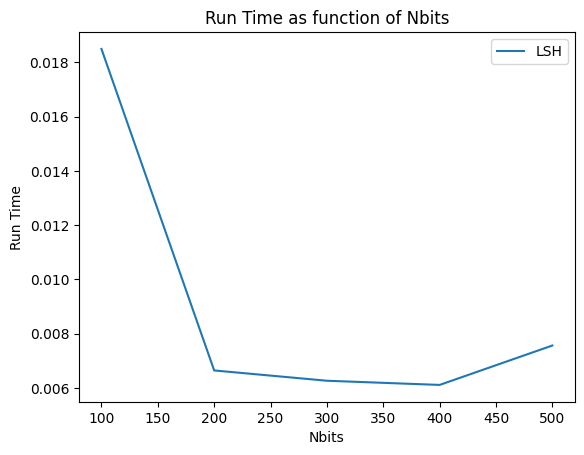

In [ ]:
#TODO: Write your code for 1.2.2 here
dim = 100
n_queries = 1000
nbits = [100, 200, 300, 400, 500]
n_index = 500000 # CHANGE TO 500,000!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
run_time = []
k = 5

queries = np.float32(generate_vectors(n_queries, dim, "uniform"))
index = np.float32(generate_vectors(n_index, dim, "uniform"))

for n in nbits:
  index_faiss = build_faiss_lsh_index(index, dim, n)
  start_faiss = time()
  faiss_search(queries, index_faiss, k)
  run_time.append(time()-start_faiss)


plt.plot(nbits, run_time, label="LSH")
plt.legend()
plt.xlabel("Nbits")
plt.ylabel("Run Time")
plt.title("Run Time as function of Nbits")
plt.savefig('img122.png', bbox_inches='tight')
plt.show()

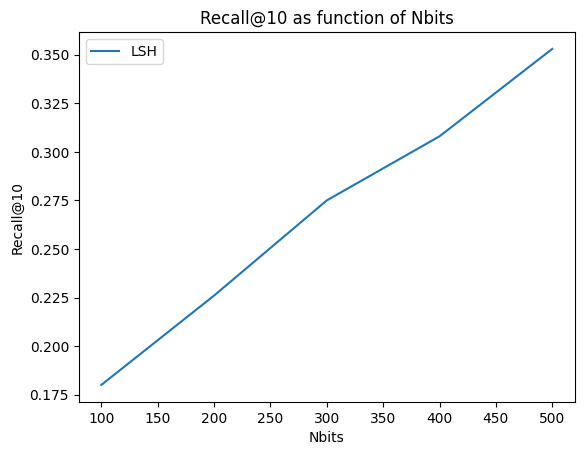

In [ ]:
#TODO: Write your code for 1.2.3 here
dim = 100
n_queries = 100
nbits = [100, 200, 300, 400, 500]
n_index = 100000 # CHANGE TO 100,000!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
recall = []
k = 10

queries = np.float32(generate_vectors(n_queries, dim, "uniform"))
index = np.float32(generate_vectors(n_index, dim, "uniform"))
gtnn = optimized_exhaustive_search(queries, index, k)

for n in nbits:
  index_faiss = build_faiss_lsh_index(index, dim, n)
  ann = faiss_search(queries, index_faiss, k)
  recall.append(compute_recall_at_k(gtnn, ann, k))


plt.plot(nbits, recall, label="LSH")
plt.legend()
plt.xlabel("Nbits")
plt.ylabel("Recall@10")
plt.title("Recall@10 as function of Nbits")
plt.savefig('img123.png', bbox_inches='tight')
plt.show()